In [226]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import datetime as dt

def load_dataset(path,state_count):
    data = load_files(path)
    driver_files = np.array(data['filenames'])
    driver_targets = np_utils.to_categorical(np.array(data['target']),state_count)
    print()
    return driver_files, driver_targets

# load driver state
driver_state = [item[20:-1] for item in sorted(glob("imgs/train/*/"))]

# load train dataset
train_files, train_targets = load_dataset('imgs/train',len(driver_state))

# print summary
print('There are %d total driver states.' % len(driver_state))
print('There are %d training driver images.' % len(train_files))



There are 3 total driver states.
There are 7073 training driver images.


Number of faces detected: 0


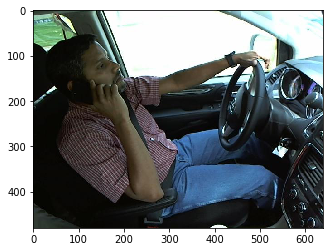

In [227]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 加载彩色（通道顺序为BGR）图像
img = cv2.imread(train_files[65])

# 将BGR图像进行灰度处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在图像中找出脸
faces = face_cascade.detectMultiScale(gray)

# 打印图像中检测到的脸的个数
print('Number of faces detected:', len(faces))

# 获取每一个所检测到的脸的识别框
for (x,y,w,h) in faces:
    # 在人脸图像中绘制出识别框
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# 将BGR图像转变为RGB图像以打印
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 展示含有识别框的图像
plt.imshow(cv_rgb)
plt.show()

In [228]:
start = dt.datetime.now()

# Use Keras Pretrained Models dataset

In [229]:
INPUT_SIZE = 224
NUM_CLASSES = len(driver_state)
SEED = 1992
Classes = 2

In [230]:
from keras.preprocessing import image                  
from tqdm import tqdm

def read_img(img_path,size):
    img = image.load_img(img_path, target_size=(size, size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [231]:
x_train = np.zeros((len(train_files), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

In [232]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [233]:
for i, img_path in tqdm(enumerate(train_files)):
    x = preprocess_input(path_to_tensor(img_path,INPUT_SIZE))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

7073it [01:09, 102.33it/s]


Train Images shape: (7073, 224, 224, 3) size: 1,064,684,544


In [234]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train_targets))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train_targets[train_idx]
yv = train_targets[valid_idx]

In [235]:
RESNETWEIGHT = 'weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [195]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
resnet_bottleneck = ResNet50(weights=RESNETWEIGHT, include_top=False,pooling='avg')
train_resnet_bf = resnet_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_resnet_bf = resnet_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('RESNET train bottleneck features shape: {} size: {:,}'.format(train_resnet_bf.shape, train_resnet_bf.size))
print('RESNET valid bottleneck features shape: {} size: {:,}'.format(valid_resnet_bf.shape, valid_resnet_bf.size))

((3749, 224, 224, 3), (1007, 224, 224, 3), (3749, 2), (1007, 2))
  32/3749 [..............................] - ETA: 1:09:45

KeyboardInterrupt: 

In [185]:
np.savez("bottleneck_f/bottleneck_features_traintest.npz", 
                                    train = train_resnet_bf, 
                                    valid = valid_resnet_bf)

In [196]:
BottleneckFeatures = np.load("bottleneck_f/bottleneck_features_traintest.npz")
train_resnet_bf = BottleneckFeatures['train']
valid_resnet_bf = BottleneckFeatures['valid']

# Use the Logistic Regression

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

In [236]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_resnet_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_resnet_bf)
valid_preds = logreg.predict(valid_resnet_bf)

ValueError: Found input variables with inconsistent numbers of samples: [3749, 5680]

In [199]:
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG Accuracy 0.9990069513406157


# Fine tuining with Keras 

In [210]:
# Creat model
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 

from keras.models import Model

In [215]:
from keras.applications.resnet50 import ResNet50, preprocess_input
model = Sequential()
model.add(Dense(NUM_CLASSES, activation='softmax',input_shape=train_resnet_bf.shape[1:]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [216]:
## compile
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [219]:
## Training

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.RESNET50222.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_resnet_bf, ytr, 
          validation_data=(valid_resnet_bf, yv),
          epochs=64, batch_size=32, callbacks=[checkpointer], verbose=0)


Epoch 00001: val_loss improved from inf to 0.00071, saving model to saved_models/weights.best.RESNET50222.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss improved from 0.00071 to 0.00056, saving model to saved_models/weights.best.RESNET50222.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss improved from 0.00056 to 0.00045, saving model to saved_models/weights.best.RESNET50222.hdf5

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss improved from 0.00045 to 0.00043, saving model to saved_models/weights.best.RESNET50222.hdf5

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss improved from 0.00043 to 0.00037, saving model to saved_models/weights.best.RESNET50222.hdf5

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not imp

In [220]:
## test
RESNET50_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in valid_resnet_bf]

## print accuracy
test_accuracy = 100*np.sum(np.array(RESNET50_predictions)==np.argmax(yv, axis=1))/len(RESNET50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 100.0000%


In [225]:
end = dt.datetime.now()
print(start-end)

-1 day, 21:49:52.810440
